In [ ]:
!pip install onnxruntime
!pip install onnx

In [ ]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
model_path = '/content/drive/MyDrive/my_projects/tinyyolov2-7.onnx'
session = ort.InferenceSession(model_path)

# Get model metadata
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Prepare input data
# Assuming the model expects a single input of shape [batch_size, channels, height, width]
# Create a dummy input for demonstration purposes
input_data = np.random.rand(1, 3, 416, 416).astype(np.float32)

# Run inference
result = session.run([output_name], {input_name: input_data})
# Get the predictions
predictions = result[0]
print(predictions.shape)

# output => (1, 125, 13, 13)

(1, 125, 13, 13)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

In [ ]:
# Initialization
anchors = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]
class_names = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cow',
               'Dining Table', 'Dog', 'Horse', 'Motorbike', 'Person', 'Potted Plant', 'Sheep', 'Sofa',
               'Train', 'TV monitor']
model_path = '/content/drive/MyDrive/my_projects/tinyyolov2-7.onnx'
session = ort.InferenceSession(model_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 0, 0),
    (0, 128, 0), (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128), (255, 165, 0), (165, 42, 42),
    (127, 255, 0), (210, 105, 30), (220, 20, 60), (0, 100, 0), (178, 34, 34), (255, 215, 0)
]

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def output_processing(outputs, anchors, confidence_threshold):
    grid_width, grid_height, num_classes, box_per_cell = 13, 13, 20, 5
    scores = []
    boxes = []
    class_score = []
    class_ids = []
    for cy in range(grid_width):
        for cx in range(grid_height):
            for b in range(box_per_cell):
                channel = b * (num_classes + 5)
                # Extract features from the output of model
                tx = outputs[channel, cy, cx]
                ty = outputs[channel + 1, cy, cx]
                tw = outputs[channel + 2, cy, cx]
                th = outputs[channel + 3, cy, cx]
                tc = outputs[channel + 4, cy, cx]
                confidence = sigmoid(tc)

                class_score = outputs[channel + 5:channel + 25, cy, cx]
                # Transform the output variables
                x = (float(cx) + sigmoid(tx)) * 32
                y = (float(cy) + sigmoid(ty)) * 32
                w = np.exp(tw) * 32 * anchors[2 * b]
                h = np.exp(th) * 32 * anchors[2 * b + 1]
                left = int(x - w / 2)
                top = int(y - h / 2)
                right = int(x + w / 2)
                bottom = int(y + h / 2)

                class_score = softmax(class_score)  # Finding the probabilities of each class_score
                best_class = np.argmax(class_score)  # Taking out the one with max probability
                best_class_score = class_score[best_class]
                confidence_in_class = best_class_score * confidence
                # Updating boxes, scores, class_ids
                boxes.append([left, top, right, bottom])
                scores.append(float(confidence_in_class))
                class_ids.append(int(best_class))
    return boxes, scores, class_ids

In [ ]:
def postprocess(image, boxes, scores, class_ids, indices, class_names, colors, confidence_threshold):
    detected = []
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        if scores[i] > confidence_threshold:
            color = colors[class_ids[i]]
            #making boxes and labels
            cv2.rectangle(image, (left, top), (right, bottom), color, 2)
            text = f'{class_names[class_ids[i]]}: {scores[i] * 100:.2f}%'
            cv2.putText(image, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            detected.append(class_names[class_ids[i]])
            print(f'{class_names[class_ids[i]]}: {scores[i] * 100:.2f}%')

In [ ]:
def preprocess_and_finaloutput(image_path, anchors, class_names, confidence_threshold=0.4, nms_threshold=0.4):
    image = cv2.imread(image_path)
    image_new = np.array(image)
    image_new = cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB)
    image_new = np.expand_dims(image_new.transpose(2, 0, 1), axis=0)
    outputs = session.run([output_name], {input_name: image_new.astype(np.float32)})
    boxes, scores, class_indices = output_processing(outputs[0][0], anchors, confidence_threshold)
    indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, nms_threshold)
    print("Objects present:")
    postprocess(image, boxes, scores, class_indices, indices, class_names, colors, confidence_threshold)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Objects present:


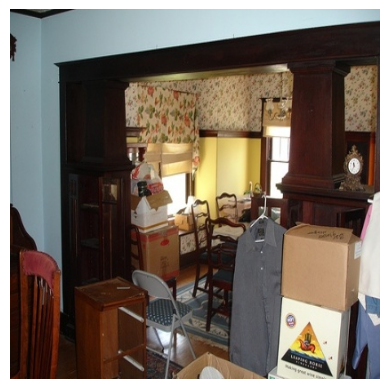

Objects present:
Car: 77.96%


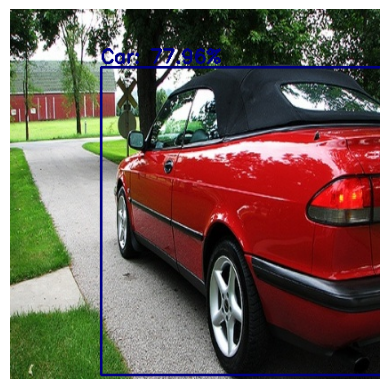

Objects present:
Person: 61.69%
Person: 50.77%
Horse: 41.61%


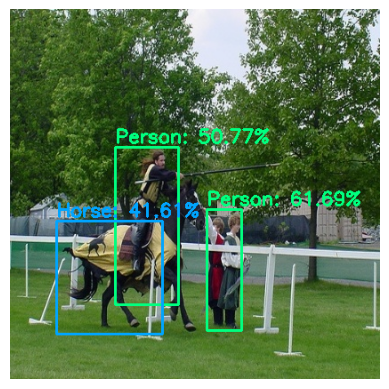

Objects present:
Car: 77.75%


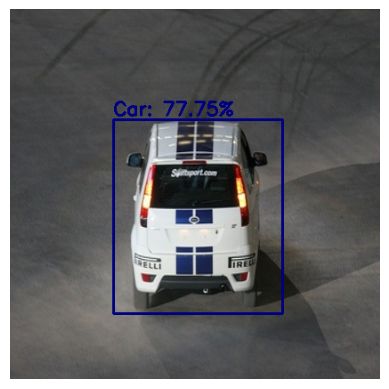

Objects present:
Bicycle: 87.28%


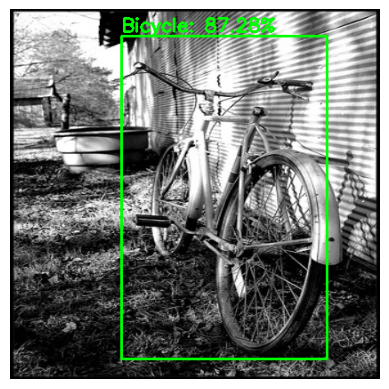

Objects present:
Person: 95.04%
Horse: 93.75%


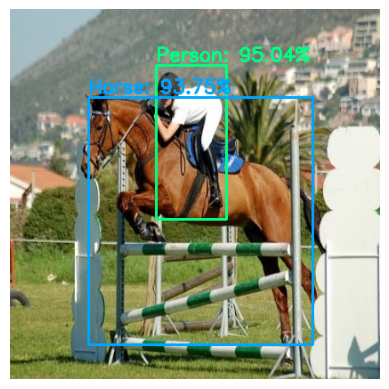

Objects present:
Cat: 94.98%
Cat: 52.24%


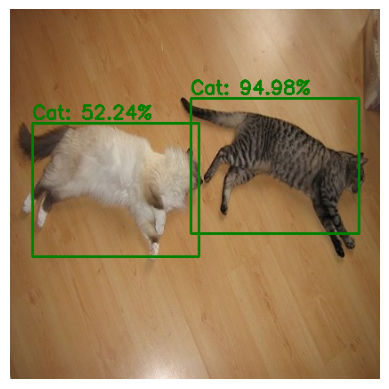

Objects present:
Car: 66.80%


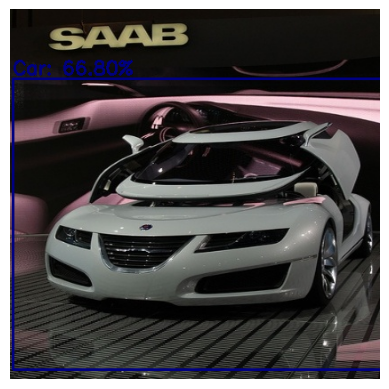

Objects present:
Person: 94.30%
Person: 85.61%
Dog: 78.76%


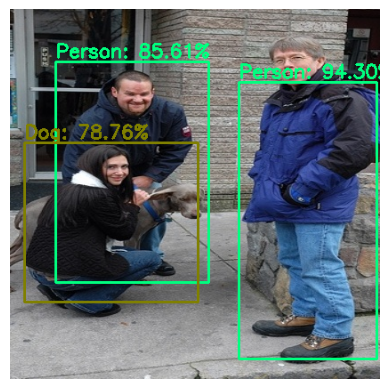

Objects present:
Person: 80.97%
Bicycle: 78.07%
Person: 76.97%
Bicycle: 50.30%


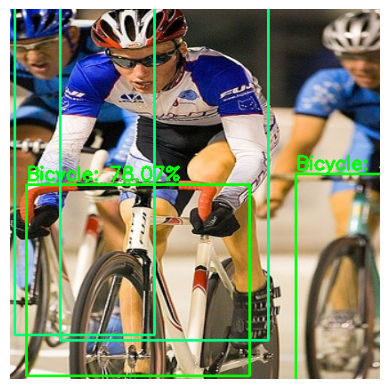

In [ ]:
def object_detection(image_path):
    preprocess_and_finaloutput(image_path, anchors, class_names)

# Loop over images
for i in range(1, 11):
    image_path = f'/content/drive/MyDrive/Colab_Notebooks/Image/{i}.jpg'
    object_detection(image_path)
